In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as smp

In [60]:
dataset = pd.read_csv('datasets/IN4148_10K.csv', names=['vrawout','vraw1', 'vraw2'])

In [61]:
dataset['Duty'] = dataset['vrawout']/256
dataset['VRD'] = dataset['vraw1']/1024*5
dataset['VD'] =  dataset['vraw2']/1024*5

In [62]:
dataset.head()

vrawout  vraw1  vraw2      Duty       VRD        VD
0        0     14      4  0.000000  0.068359  0.019531
1        1      7      5  0.003906  0.034180  0.024414
2        2      0      0  0.007812  0.000000  0.000000
3        3      0      0  0.011719  0.000000  0.000000
4        4      6      6  0.015625  0.029297  0.029297

In [5]:
dataset.tail()

vrawout  vraw1  vraw2      Duty       VRD        VD
251      251    879    112  0.980469  4.291992  0.546875
252      252    883    113  0.984375  4.311523  0.551758
253      253    887    112  0.988281  4.331055  0.546875
254      254    890    113  0.992188  4.345703  0.551758
255      255    895    112  0.996094  4.370117  0.546875

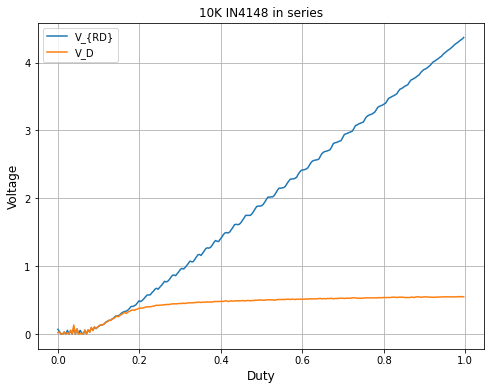

In [6]:
#plt.rcParams["figure.figsize"]=8,8
fig, ax = plt.subplots(1,1, figsize=(8,6))


ax.set_title("10K IN4148 in series")
duty = dataset['Duty']
vrd = dataset['VRD']
vd = dataset['VD']
ax.plot(duty, vrd, label='V_{RD}')
ax.plot(duty, vd, label='V_D')
ax.set_xlabel("Duty", fontsize=12)
ax.set_ylabel("Voltage", fontsize=12)
ax.legend()
ax.grid()

In [64]:
dataset['ID'] = (dataset['VRD']- dataset['VD'])/10000

In [65]:
dataset.tail()

vrawout  vraw1  vraw2      Duty       VRD        VD        ID
251      251    879    112  0.980469  4.291992  0.546875  0.000375
252      252    883    113  0.984375  4.311523  0.551758  0.000376
253      253    887    112  0.988281  4.331055  0.546875  0.000378
254      254    890    113  0.992188  4.345703  0.551758  0.000379
255      255    895    112  0.996094  4.370117  0.546875  0.000382

In [63]:
dataset.head()

vrawout  vraw1  vraw2      Duty       VRD        VD
0        0     14      4  0.000000  0.068359  0.019531
1        1      7      5  0.003906  0.034180  0.024414
2        2      0      0  0.007812  0.000000  0.000000
3        3      0      0  0.011719  0.000000  0.000000
4        4      6      6  0.015625  0.029297  0.029297

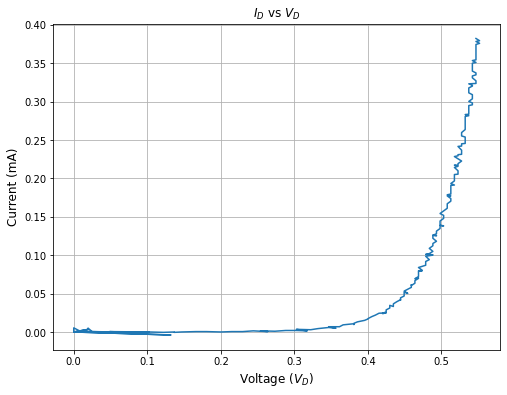

In [66]:
#plt.rcParams["figure.figsize"]=8,8
fig, ax = plt.subplots(1,1, figsize=(8,6))


ax.set_title("$I_D$ vs $V_D$")

ax.plot(vd, dataset['ID']*1000)
ax.set_xlabel("Voltage ($V_D$)", fontsize=12)
ax.set_ylabel("Current (mA)", fontsize=12)
ax.grid()

In [67]:
from scipy.optimize import curve_fit, least_squares
from numpy import exp

In [68]:
def fmodel(v, isv, k):
    return isv*(exp(v/k)-1)

In [69]:
curve_fit(fmodel, dataset['VD'], dataset['ID'], (1e-8, 0.258), absolute_sigma=True)

(array([7.87675051e-09, 5.09995477e-02]),
 array([[5.85408665e-09, 3.62295898e-03],
        [3.62295898e-03, 2.24458583e+03]]))

In [70]:
sisv, svd, sid, sk = smp.symbols('I_S V_D I_D k')
expr = smp.Eq(sid , sisv * (smp.exp(svd/sk) - 1))
expr

Eq(I_D, I_S*(exp(V_D/k) - 1))

In [71]:
j2  = smp.diff(expr.args[1], sk)
j2

-I_S*V_D*exp(V_D/k)/k**2

In [72]:
j1  = smp.diff(expr.args[1], sisv)
j1

exp(V_D/k) - 1

In [73]:
j1f = smp.lambdify([svd, sisv, sk], j1)
j2f = smp.lambdify([svd, sisv, sk], j2)
def jacfun(x, isv, k):
    return np.transpose(np.array([j1f(x, isv, k), j2f(x, isv, k)]))

In [74]:
jacfun(2, 1e-24, 0.28)

array([ 1.26403762e+03, -3.22713680e-20])

In [82]:
popt, pcov = curve_fit(fmodel, dataset['VD'], dataset['ID'], (1e-14, 0.258), absolute_sigma=True, method='trf')
popt

/home/splat/venvs/jupyter-notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([7.87674935e-09, 5.09995470e-02])

In [84]:
np.sqrt(np.diag(pcov))

array([7.65125763e-05, 4.73772483e+01])

In [85]:
pcov

array([[5.85417434e-09, 3.62300050e-03],
       [3.62300050e-03, 2.24460365e+03]])

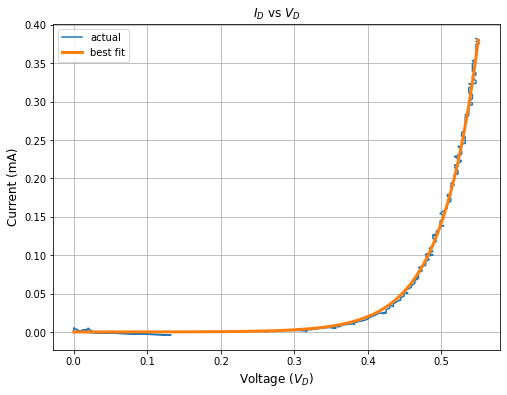

In [81]:
#plt.rcParams["figure.figsize"]=8,8
fig, ax = plt.subplots(1,1, figsize=(8,6))

x = np.linspace(0, 0.55, 1000)
y = popt[0]*(np.exp(x/popt[1])-1)
ax.set_title("$I_D$ vs $V_D$")

ax.plot(vd, dataset['ID']*1000, label='actual')
ax.plot(x,y*1000, label = 'best fit', linewidth=3)
ax.set_xlabel("Voltage ($V_D$)", fontsize=12)
ax.set_ylabel("Current (mA)", fontsize=12)
ax.legend()
ax.grid()